## 1. Imports and Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Data Generation

We'll generate synthetic data for training based on the function sin(x*y).

In [98]:
num_inputs = 7*2*3 #42
weights = np.linspace(0.5, 0.1, num_inputs)   # Decreasing weights: 0.5, 0.4, ..., 0.1

def func_to_approx(inputs):
    return np.dot(inputs, weights) + np.sin(inputs[:, 0])

def generate_data(num_samples=1000):
    inputs = np.random.randn(num_samples, num_inputs)  # Random inputs
    noise = 0.01 * np.random.randn(num_samples)
    output = func_to_approx(inputs) + noise
    inputs = torch.tensor(inputs, dtype=torch.float32)
    output = torch.tensor(output, dtype=torch.float32).reshape(-1,1)

    return inputs, output

inputs, output =generate_data()
inputs.shape, output.shape

(torch.Size([1000, 42]), torch.Size([1000, 1]))

In [23]:

BATCH_SIZE = 64

# Create datasets
train_inputs, train_targets = generate_data(num_samples=10000)
val_inputs, val_targets = generate_data(num_samples=2000)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_inputs, val_targets)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 10000
Validation samples: 2000


In [24]:
for inputs, targets in train_loader:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([64, 42])
torch.Size([64, 1])


## 3. Model Definition

We'll define a fully connected neural network with configurable input size, hidden layers, and output size.

In [25]:
# Model architecture parameters (adjustable)
INPUT_SIZE = 42
HIDDEN_LAYERS = [128, 128, 128]
OUTPUT_SIZE = 1

class SinModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_layers=HIDDEN_LAYERS, output_size=OUTPUT_SIZE):
        super(SinModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize model
model = SinModel().to(DEVICE)
print(model)

SinModel(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 4. Training Loop

In [26]:
import time

# Training parameters
# LEARNING_RATE = 0.001
LEARNING_RATE = 0.0005
EPOCHS = 200 #1000

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics
train_losses = []
val_losses = []

start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress every 100 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {time.time() - start_time:.2f}s')

print("Training complete!")

Epoch [50/200], Train Loss: 0.0022, Val Loss: 0.0128, Time: 5.17s
Epoch [100/200], Train Loss: 0.0012, Val Loss: 0.0087, Time: 10.27s
Epoch [150/200], Train Loss: 0.0008, Val Loss: 0.0095, Time: 15.33s
Epoch [200/200], Train Loss: 0.0007, Val Loss: 0.0067, Time: 20.33s
Training complete!


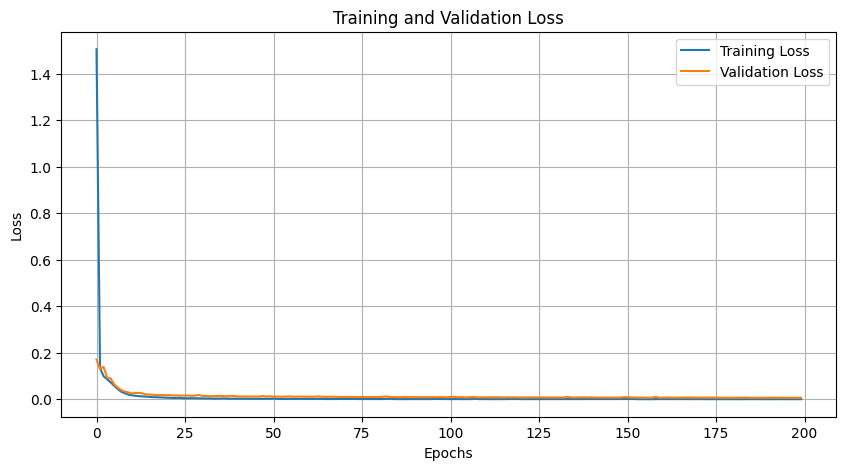

In [27]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Evaluation

In [ ]:
num_test_points = 10000
test_inputs, test_targets = generate_data(num_samples=num_test_points)

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(test_inputs.to(DEVICE)).cpu().numpy()

# Calculate MSE and max error
errors = predictions - test_targets.numpy()
rms_error = np.mean(errors ** 2)
max_error = np.max(errors)
min_error = np.min(errors)
print(f'Test MSE: {rms_error:.4f}')

# get percentage of errors below 10%
below_10_percent = np.sum(np.abs(errors) < 0.1) / num_test_points
print(f'Percentage of errors below 10%: {below_10_percent:.2%}')

# get percentage of errors below 5%
below_5_percent = np.sum(np.abs(errors) < 0.05) / num_test_points
print(f'Percentage of errors below 5%: {below_5_percent:.2%}')

Test MSE: 0.0067
Percentage of errors below 10%: 82.58%
Percentage of errors below 5%: 51.84%


# Export

In [92]:
import os
import nobuco
from nobuco import ChannelOrder, ChannelOrderingStrategy
from nobuco.layers.weight import WeightLayer

model_name = "piecewise_model_128"

export_dir = "./export"
os.makedirs(export_dir, exist_ok=True)

#torch file
torch.save(model, f"{export_dir}/{model_name}_torch.pth")

#keras file
dummy_input = torch.rand(size=(1,INPUT_SIZE))
keras_model = nobuco.pytorch_to_keras(
    model.eval(),
    args=[dummy_input], kwargs=None,
    inputs_channel_order=ChannelOrder.PYTORCH,
    outputs_channel_order=ChannelOrder.PYTORCH,
)
keras_model.save(f"{export_dir}/{model_name}_keras")

[Nobuco] Tracing (DONE): : 10ops [00:00, 416.56ops/s]
[Nobuco] Converting (DONE): 100%|██████████| 7/7 [00:00<00:00, 159.38ops/s]

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

SinModel[__main__](float32_0<1,42>) -> float32_15<1,1>
 ├· Sequential[torch.nn.modules.container](float32_0<1,42>) -> float32_15<1,1>
 │   │  Linear[torch.nn.modules.linear](float32_0<1,42>) -> float32_3<1,128>
 │   │   └· linear[torch.nn.functional](float32_0<1,42>, float32_1<128,42>, float32_2<128>) -> float32_3<1,128>
 │   │  ReLU[torch.nn.modules.activation](float32_3<1,128>) -> float32_4<1,128>
 │   │   ├· relu[torch.nn.functional](float32_3<1,128>, inplace=False) -> float32_4<1,128>
 │   │   └   └· relu[torch](float32_3<1,128>) -> float32_4<1,128>
 │   │  Linear[torch.nn.modules.linear](float32_4<1,128>) -> float32_7<1,128>
 │

INFO:tensorflow:Assets written to: ./export/piecewise_model_128_keras/assets


INFO:tensorflow:Assets written to: ./export/piecewise_model_128_keras/assets


In [108]:
import tensorflow as tf

def representative_data_gen():
    for _ in range(10000):  # Use 1000 samples for calibration
        input_value = np.random.uniform(-1, 1, size=(INPUT_SIZE)).astype(np.float32)  
        yield [input_value]  # Wrap in a list since the model expects batched input
    
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)  # Create a converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimizations (quantization)
converter.target_spec.supported_types = [tf.int8]  # Limit model to int8
converter.representative_dataset = representative_data_gen  # Use sample data for calibration
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Ensure int8 ops
converter.inference_input_type = tf.int8  # Input tensor type
converter.inference_type = tf.int8  # Internal computation type
converter.inference_output_type = tf.int8  # Output tensor type
# converter.inference_output_type = tf.float32  # Reduce output quantization error

tflite_model = converter.convert()
with open(f"{export_dir}/{model_name}.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmp1g9fcp3l/assets


INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmp1g9fcp3l/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-13 23:02:03.253513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-13 23:02:03.253523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-13 23:02:03.253634: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmp1g9fcp3l
2025-03-13 23:02:03.254168: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-13 23:02:03.254174: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/fm/j5zs

In [109]:
interpreter = tf.lite.Interpreter(model_path=f"{export_dir}/{model_name}.tflite")
interpreter.allocate_tensors()


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for input_detail in input_details:
    print(input_detail)
for output_detail in output_details:
    print(output_detail)

{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([ 1, 42], dtype=int32), 'shape_signature': array([ 1, 42], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007843103259801865, 0), 'quantization_parameters': {'scales': array([0.0078431], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.03959125280380249, -3), 'quantization_parameters': {'scales': array([0.03959125], dtype=float32), 'zero_points': array([-3], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [110]:
import os
import json

os.system(f"xxd -i {export_dir}/{model_name}.tflite > {export_dir}/{model_name}.cpp")

pytorch_model_str = repr(model)

input_details_str = json.dumps(input_details[0], indent=2, default=str)
output_details_str = json.dumps(output_details[0], indent=2, default=str)

# Prepend attributes and input/output details to the cpp file
with open(f"{export_dir}/{model_name}.cpp", "r") as f:
    cpp_content = f.read()

cpp_content = cpp_content.replace(f"unsigned char __export_{model_name}_tflite[] ", f"unsigned const char {model_name}[] DATA_ALIGN_ATTRIBUTE")
cpp_content = cpp_content.replace(f"unsigned int __export_{model_name}_tflite_len", f"unsigned const int {model_name}_len")


prepend_content = f'''
#include "{model_name}.h"

// We need to keep the data array aligned on some architectures.
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
/*
{pytorch_model_str}

Input details:
{input_details_str}

Output details:
{output_details_str}
*/

'''

# Write the modified content back to the file
with open(f"{export_dir}/{model_name}.cpp", "w") as f:
    f.write(prepend_content + cpp_content)


# Create a header file
header_file_content = f'''
#ifndef {model_name.upper()}
#define {model_name.upper()}

extern const unsigned char {model_name}[];
extern const unsigned int {model_name}_len;

#endif      
'''
with open(f"{export_dir}/{model_name}.h", "w") as f:
    f.write(header_file_content)


In [111]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 12,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([1, 1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.03959125280380249, -3),
  'quantization_parameters': {'scales': array([0.03959125], dtype=float32),
   'zero_points': array([-3], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

Quantization error RMS: 0.29%
Percentage of errors below 2%: 80.19%
Percentage of errors below 5%: 99.95%
99% of errors are below: 3.66%
97% of errors are below: 3.18%


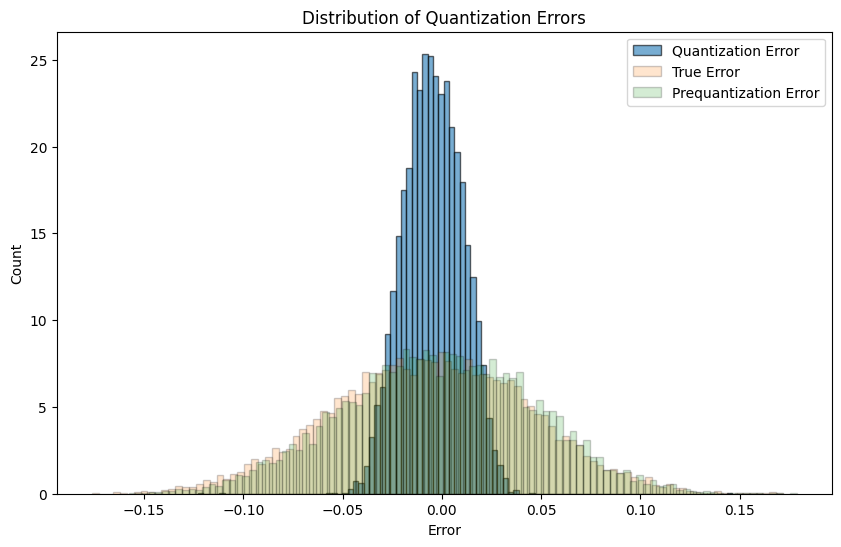

In [258]:
# test quantized model
num_test_points = 10000

#get quantization parameters from input details
input_scale = input_details[0]['quantization_parameters']['scales'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]

input_float = np.random.uniform(-1, 1, size=(num_test_points,INPUT_SIZE))

# input_quantized = np.round(input_float / input_scale + input_zero_point).astype(np.int8)
input_quantized = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)

input_quantized = input_quantized.reshape((-1,INPUT_SIZE))

output_data = np.zeros((num_test_points,OUTPUT_SIZE))
for i in range(num_test_points):
    interpreter.set_tensor(input_details[0]['index'], input_quantized[i].reshape((1,INPUT_SIZE)))
    interpreter.invoke()
    output_data[i] = interpreter.get_tensor(output_details[0]['index'])

# Get the quantization parameters from the output details
output_scale = output_details[0]['quantization_parameters']['scales'][0]
output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]

output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale

true_val = func_to_approx(input_float)
pre_quant = keras_model.predict(input_float.reshape((-1,INPUT_SIZE)), verbose=0)

quant_error = pre_quant - output_data_float
true_error = true_val - output_data_float.flatten()
prequant_error =  true_val - pre_quant.flatten()

rms_error = np.sqrt(np.mean(quant_error ** 2)) / np.max(np.abs(true_val))
max_error = np.max(quant_error) / np.max(np.abs(true_val))
min_error = np.min(quant_error) / np.max(np.abs(true_val))
print(f'Quantization error RMS: {rms_error:.2%}')

# get percentage of errors below 2%
below_2_percent = np.sum(np.abs(quant_error) < 0.02) / num_test_points
print(f'Percentage of errors below 2%: {below_2_percent:.2%}')

# get percentage of errors below 5%
below_5_percent = np.sum(np.abs(quant_error) < 0.05) / num_test_points
print(f'Percentage of errors below 5%: {below_5_percent:.2%}')

# percent error where 99% of errors are below this value
percent_error_99 = np.percentile(np.abs(quant_error), 99)
print(f'99% of errors are below: {percent_error_99:.2%}')

# percent error where 97% of errors are below this value
percent_error_97 = np.percentile(np.abs(quant_error), 97)
print(f'97% of errors are below: {percent_error_97:.2%}')

# Create histogram of quantization errors
plt.figure(figsize=(10, 6))
plt.hist(quant_error.flatten(), bins=100, edgecolor='black', alpha=0.6, label='Quantization Error', density=True)
plt.hist(true_error.flatten(), bins=100, edgecolor='black', alpha=0.2, label='True Error', density=True)
plt.hist(prequant_error.flatten(), bins=100, edgecolor='black', alpha=0.2, label='Prequantization Error', density=True)
plt.title('Distribution of Quantization Errors')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

In [193]:
np.max(np.abs(true_val))

5.098274096535212

In [169]:
#check output from ESP32

input_arr = [-0.408691, 0.437988, -0.940918, 0.882324, 0.351562, -0.757324, 0.149414, 0.138672, -0.560547, 0.874023, 0.345215, 0.195801, -0.579590, -0.077637, -0.139648, 0.536133, 0.252441, -0.216797, -0.665527, 0.402832, -0.377930, 0.065918, -0.197266, 0.588867, 0.310547, 0.821777, -0.488281, 0.793457, 0.765625, 0.857422, -0.972168, 0.366211, 0.315918, 0.244141, 0.493652, 0.587891, -0.682129, -0.344238, -0.627930, 0.834961, -0.599121, 0.222168]
input_quantized = np.clip(np.round(input_arr / input_scale + input_zero_point), -128, 127).astype(np.int8)


interpreter.set_tensor(input_details[0]['index'], input_quantized.reshape((1,INPUT_SIZE)))
interpreter.invoke()
output_data_int = interpreter.get_tensor(output_details[0]['index'])

output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
output_data_int, output_data_float

(array([[7]], dtype=int8), array([[0.39591253]], dtype=float32))

## 6. Export to ONNX (unused)

The ONNX format allows us to deploy our model in various environments and frameworks.

In [14]:
def export_to_onnx(model, filename='sin_model.onnx'):
    """Export the trained model to ONNX format"""
    # Create a dummy input tensor with the correct shape
    dummy_input = torch.randn(1, INPUT_SIZE, device=DEVICE)
    
    # Export the model
    torch.onnx.export(
        model,                       # model being run
        dummy_input,                 # model input (or a tuple for multiple inputs)
        filename,                    # where to save the model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=12,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['input'],       # the model's input names
        output_names=['output'],     # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model exported to {filename}")

# Export the model to ONNX
export_to_onnx(model)

Model exported to sin_model.onnx
